In [ ]:
#A notebook for working on the kaggle MNIST digit recognition dataset

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimp
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

In [7]:
#read in all the data
train = pd.read_csv("digit-recognizer/train.csv")
test = pd.read_csv("digit-recognizer/test.csv")

Y_train = train["label"]
X_train = train.drop(labels=["label"],axis=1) #drop the label column

#free up space
del train

#g=sns.countplot(Y_train)
#Y_train.value_counts()

In [12]:
#check to see if any data is null
X_train.isnull().any().describe()
test.isnull().any().describe()

#nothing is null, proceed as followed

count       784
unique        1
top       False
freq        784
dtype: object

In [13]:
#normalize data --> convert to grayscale
X_train = X_train / 255.0
test = test / 255.0

#reshape data in 3 dimensions: height = 28px, width = 28px, depth = 1: 3D matrices to feed into Keras
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

#encode labels to vectors, so 2 is encoded as [0,0,1,0,0,0,0,0,0,0]
Y_train = to_categorical(Y_train,num_classes=10)

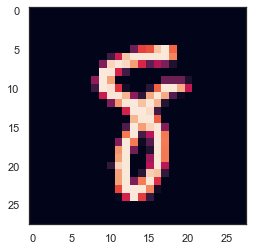

In [17]:
#split training and validation data
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train,test_size=0.1,random_state=random_seed)

g=plt.imshow(X_train[0][:,:,0])



#preprocessing end ----------------------------------

In [18]:
#Part 3: CNN. Using Keras Sequential API, adding 1 layer at a time.
#first layer: convolutional (Conv2D) layer, a set of learnable filters to transform the image
#second layer: pooling (MaxPool2D) layer, acts as a downsampling filter, looking at 2 neighboring pixels and choosing max value

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25)) #drops out 25% of model to prevent overfitting


model.add(Flatten()) #flattens the matrix to 1 array: makes sense as this is the FC, the final layer in the CNN
model.add(Dense(256, activation = "relu")) #Dense houses the activation functions
model.add(Dropout(0.5)) #drop 50% of the data out
model.add(Dense(10, activation = "softmax")) #nonlinear optimizer


# need to define the optimizer to improve accuracy by minimizing losses
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer to make the optimizer converge faster
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1,factor=0.5, min_lr=0.00001)

epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [19]:
# With data augmentation to prevent overfitting (accuracy 0.99286), a keras library

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [20]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/1
 - 124s - loss: 0.5280 - accuracy: 0.8307 - val_loss: 0.0987 - val_accuracy: 0.9667


C:\Users\haris\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
